Find articles that made it to certain journals and compare key words. This time we'll only look at articles in the physics.atom-ph section.

In [1]:
#Need to add parent directoy to sys.path to find 'metadataDB'
import sys
sys.path.append('../../')

%matplotlib inline
import matplotlib.pyplot as plt 
import time
import numpy as np
from collections import Counter
import re
import json

# Natural language processing toolkit
# To use this, run nltk.download() and download 'stopwords'
from nltk.corpus import stopwords
s=stopwords.words('english') + ['']

# SQL
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from metadataDB.declareDatabase import *
from sqlalchemy import or_, and_

engine = create_engine("sqlite:///../../arXiv_metadata.db", echo=False)
Base.metadata.bind = engine
DBsession = sessionmaker(bind=engine)
session = DBsession()

In [2]:
categories = ['atom-ph', 'quant-ph', 'cond-mat', 'hep-th']
# results = keywords('atom-ph')

# PRL: 36533 words
# Nature: 14024 words
# Frequency: quantum: 355/14024 = 0.0253137 in Nature, 314/36533 = 0.00859496 in PRL

In [4]:
def keywords(category):
    queryPRL = session.query(Article_Category)\
                    .join(Category)\
                    .join(Article)\
                    .filter(Category.name.like('%' + category + '%'),
                            or_(Article.journal_ref.like('Physics Review Letters%'),
                                Article.journal_ref.like('Phys. Rev. Lett.%'),
                                Article.journal_ref.like('PRL%')))
#     resultsPRL = queryPRL.all()

    queryNature = session.query(Article_Category)\
                        .join(Category)\
                        .join(Article)\
                        .filter(Category.name.like('%' + category + '%'),
                                or_(Article.journal_ref.like('Nature%'),
                                    Article.journal_ref.like('Nat.%'),
                                    Article.journal_ref.like('Science%')))
#     resultsNature = queryNature.all()

    # Count the most frequenty words in either Nature or PRL, and report how often
    # those words show up in each journal.
    
    countPRL = Counter((word
                        for result in queryPRL
                        for word in cleanup_text(result.article.abstract)))
    countNature = Counter((word
                           for result in queryNature
                           for word in cleanup_text(result.article.abstract)))
    
    max_words = 15
    
    top_words_PRL = [x[0] for x in countPRL.most_common(max_words)]
    top_words_Nature = [x[0] for x in countNature.most_common(max_words)]
    num_words_PRL = sum(countPRL.values())
    num_words_Nature = sum(countNature.values())

    sum_counts = [ {'name': word,
                    'rank': rank,
                    'value1': countNature[word]*1./num_words_Nature,
                    'value2': countPRL[word]*1./num_words_PRL }
                    for rank, word in zip(range(1, max_words+1) + range(-max_words, 0),
                                          (top_words_Nature + top_words_PRL[::-1]))]
    

    all_words = set(countPRL.keys() + countNature.keys())
#     print len(countPRL.keys())
#     print len(countNature.keys())
#     print len(all_words)
    
    
    # How much more often does a word show up in Nature than PRL, as normalized by
    # the total number of words?
    
    difference_counts_all = sorted([ (word,
                                  countNature[word]*1./num_words_Nature - \
                                           countPRL[word]*1./num_words_PRL )
                                for word in set(countPRL.keys() + countNature.keys()) ],
                              key=lambda x: -x[1])
    difference_counts = [ {'name': x[0], 'value': x[1] }
                          for x in (difference_counts_all[0:max_words] + 
                                    difference_counts_all[-max_words:]) ]
    
    return (sum_counts, difference_counts)

    
    
def cleanup_text(paragraph):
    return [ x for x in re.sub('[^a-z ]', '',
                  re.sub('[\n]', ' ', paragraph.lower().strip())).split()
            if x  not in s ]



In [7]:
final_dict1 = dict()
final_dict2 = dict()
for category in categories:
    result = keywords(category)
    final_dict1[category.replace('-', '_')] = result[0]
    final_dict2[category.replace('-', '_')] = result[1]
#     break
# print json.dumps(final_dict1)
print json.dumps(final_dict2)
# with open('../../widgets/data1.json', 'wb') as f:
#     json.dump(final_dict1, f)
with open('keywords-difference.json', 'wb') as f:
    json.dump(final_dict2, f)

{"hep_th": [{"name": "quantum", "value": 0.014763720942451604}, {"name": "matter", "value": 0.004703325902407169}, {"name": "universe", "value": 0.0046488699738041084}, {"name": "systems", "value": 0.004285936784585707}, {"name": "phase", "value": 0.0041419625901656576}, {"name": "physics", "value": 0.003751369842449354}, {"name": "experiments", "value": 0.0030862268909455292}, {"name": "system", "value": 0.0030255034640125503}, {"name": "experimental", "value": 0.003023504995233699}, {"name": "charge", "value": 0.0029947101563496895}, {"name": "superconductors", "value": 0.002629778498352436}, {"name": "fundamental", "value": 0.0025382617637565957}, {"name": "polarization", "value": 0.002426216157385515}, {"name": "liquid", "value": 0.0024210839394417046}, {"name": "may", "value": 0.002373758697561305}, {"name": "order", "value": -0.0016758239696157686}, {"name": "local", "value": -0.0016963528413910093}, {"name": "terms", "value": -0.0017251476802750193}, {"name": "large", "value": -

In [6]:
session.close_all()

In [10]:
# Want to sort dictionary by values. Convert it to a list of tuples so we can use python's sort functions
# abstract_wordlist = sorted([(key, val) for key, val in abstract.iteritems()], key=lambda x: x[1])
# title_wordlist = sorted([(key, val) for key, val in title.iteritems()], key=lambda x: x[1])

In [11]:
# abstract_best_and_worst = abstract_wordlist[0:10] + abstract_wordlist[-11:-1]
# print abstract_best_and_worst

[(u'via', -0.006423982869379015), (u'problem', -0.006423982869379015), (u'case', -0.004282655246252677), (u'linear', -0.004282655246252677), (u'degenerate', -0.004282655246252677), (u'arise', -0.004282655246252677), (u'parameter', -0.004282655246252677), (u'repulsive', -0.004282655246252677), (u'association', -0.004282655246252677), (u'always', -0.004282655246252677), (u'ultracold', 0.03559452143347743), (u'frequency', 0.03559452143347743), (u'effects', 0.03773584905660377), (u'observation', 0.03773584905660377), (u'precision', 0.03773584905660377), (u'demonstrate', 0.03773584905660377), (u'quantum', 0.04288715607450203), (u'optical', 0.052321118338652974), (u'also', 0.056603773584905655), (u'atoms', 0.05747242535655124)]


In [161]:
words = [x for (x,y) in abstract_best_and_worst]
vals = np.array([y for (x,y) in abstract_best_and_worst])


ind = np.arange(0, len(words))
c = ['b' if x > 0 else 'r' for x in vals]

plt.figure(frameon=False, figsize=(6,8))
plt.barh(ind - 0.5,
         vals,
         color=c)
plt.yticks(ind, words)
plt.ylim(ind[0]-1, ind[-1]+1)
plt.xlim(-1.1*np.max(np.abs(vals)), 1.1*np.max(np.abs(vals)))
plt.title('Abstracts')
plt.xlabel('PRL$\qquad\qquad\qquad\qquad$Nature/Science')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('none')

NameError: name 'abstract_best_and_worst' is not defined

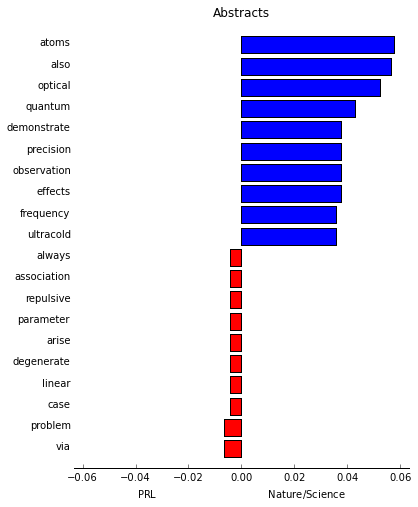

In [13]:
# words = [x for (x,y) in abstract_best_and_worst]
# vals = np.array([y for (x,y) in abstract_best_and_worst])


# ind = np.arange(0, len(words))
# c = ['b' if x > 0 else 'r' for x in vals]

# plt.figure(frameon=False, figsize=(6,8))
# plt.barh(ind - 0.5,
#          vals,
#          color=c)
# plt.yticks(ind, words)
# plt.ylim(ind[0]-1, ind[-1]+1)
# plt.xlim(-1.1*np.max(np.abs(vals)), 1.1*np.max(np.abs(vals)))
# plt.title('Abstracts')
# plt.xlabel('PRL$\qquad\qquad\qquad\qquad$Nature/Science')
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)
# plt.gca().xaxis.set_ticks_position('bottom')
# plt.gca().yaxis.set_ticks_position('none')